In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
%matplotlib inline  


In [157]:
df = pd.read_csv('./pilot.csv')
df['logs'] = df['logs'].map(lambda x: json.loads(x) if not pd.isnull(x) else pd.NA)


In [158]:
df.loc[df['participant_id'].isna(),'participant_id'] = 'test'
df['__INDEX__'] = df['__INDEX__'].map(json.loads)

df.loc[df['participant_id'] == 'arnav','participant_id'] = 1
df.loc[df['participant_id'] == 'karthik','participant_id'] = 2
df.loc[df['participant_id'] == 'majeed','participant_id'] = 3

In [159]:
df

,participant_id,metadata,tasks,DevTools,__INDEX__,participant_number,task,content,logs,menu,items,command,question,object,timeLimit,questions,filename,experimenter
0,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[0],0,InformationScreen,\nIn order to complete this experiment you wil...,"[{'type': 'START', 'timestamp': 1675110926061}...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 0]",0,Tutorial,NaN,"[{'type': 'START', 'timestamp': 1675110926938}...",KeyboardShortcutsWithCheatsheet,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 1, 0]",0,CommandSelection,NaN,"[{'type': 'START', 'timestamp': 1675110966373}...",KeyboardShortcutsWithCheatsheet,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",Italic,NaN,NaN,NaN,NaN,NaN,NaN
3,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 1, 1]",0,CommandSelection,NaN,"[{'type': 'START', 'timestamp': 1675110970603}...",KeyboardShortcutsWithCheatsheet,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",Print,NaN,NaN,NaN,NaN,NaN,NaN
4,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[1, 1, 2]",0,CommandSelection,NaN,"[{'type': 'START', 'timestamp': 1675110975532}...",KeyboardShortcutsWithCheatsheet,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",Bulleted list,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[3, 3]",2,DivergentTest,NaN,"[{'type': 'START', 'timestamp': 1675123255389}...",MarkingMenu,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",NaN,Write down all of the original and creative\n ...,shoe,180000.0,NaN,NaN,NaN
311,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[3, 4]",2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675123441446}...",MarkingMenu,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",NaN,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN
312,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}","[3, 5]",2,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675123449064}...",MarkingMenu,"[{""icon"":{""displayName"":""Undo""},""label"":""Undo""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,S3Upload,NaN,"[{'type': 'START', 'timestamp': 1675123469792}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,majeed.json,blaine@dgp.toronto.edu


# Dataframe Creation

## Selection

In [165]:
selection = df[df['task'] == 'CommandSelection'].copy()


def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    return row
selection['trial'] = selection['__INDEX__'].map(lambda x: x[2])
selection['trial_total'] = selection['__INDEX__'].map(lambda x: x[0] * x[1])

selection = selection[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

selection = selection.apply(extract_selection, axis=1)


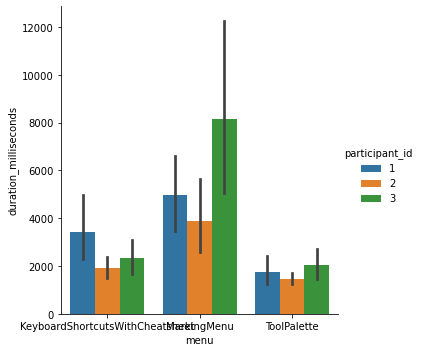

In [169]:
sns.catplot(data=selection, kind="bar", x='menu', y='duration_milliseconds', hue='participant_id')

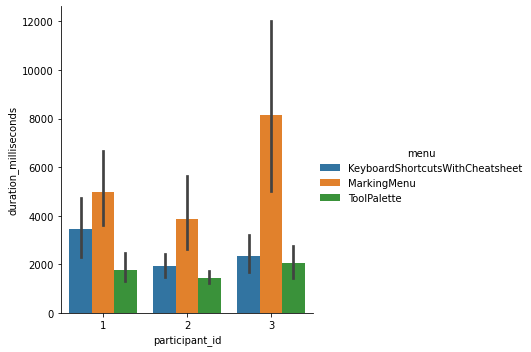

In [170]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='duration_milliseconds', hue='menu')

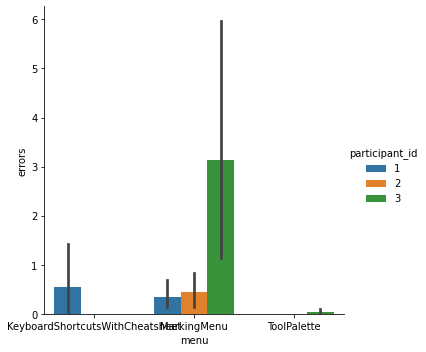

In [172]:
sns.catplot(data=selection, kind="bar", x='menu', y='errors', hue='participant_id')

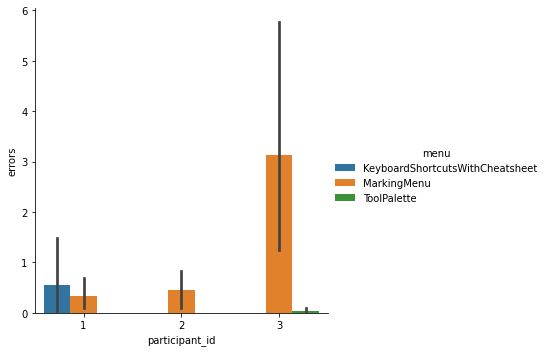

In [173]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='errors', hue='menu')

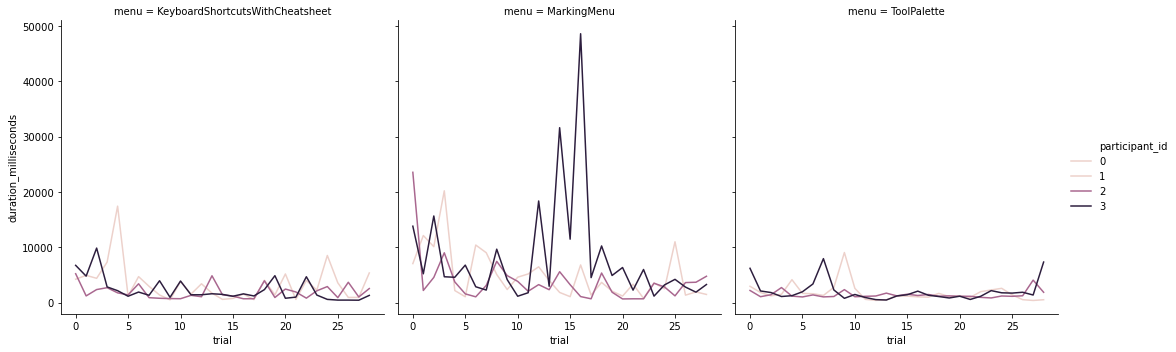

In [176]:
sns.relplot(data=selection,kind='line', x='trial', y='duration_milliseconds', hue='participant_id', col="menu")

## Creativity

In [117]:
unusual_uses = df[df['task'] == 'DivergentTest']

# TODO: so the issue here is that we have multiple rows per group.

def extract_unusual_uses(g):
    for index, row in g.iterrows():
        if not isinstance(row['logs'], list):
            return pd.Series(pd.NA)

        for log in row['logs']:
            if log['type'] == 'DivergentTest':
                new_df = pd.DataFrame(log['values'], columns=['values'])
                new_df['topTwo'] = False
                # TODO: just need to pad the Nones with some falses to make things worlk

                new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
                return new_df
        
unusual_uses = unusual_uses.groupby(['participant_id', 'menu', 'object']).apply(extract_unusual_uses).reset_index()
del unusual_uses['level_3']
# del unusual_uses[0]

In [118]:
unusual_uses[unusual_uses['topTwo']]

,participant_id,menu,object,values,topTwo
1,1,KeyboardShortcutsWithCheatsheet,shoe,as a tennis ball,True
11,1,KeyboardShortcutsWithCheatsheet,shoe,to collect seasoning off the ground,True
20,1,MarkingMenu,knife,as a research companion to talk to,True
22,1,MarkingMenu,knife,as a lightning rod,True
28,1,ToolPalette,brick,to collect some rain water and have a drink,True
37,1,ToolPalette,brick,to use as a basketball,True
39,2,KeyboardShortcutsWithCheatsheet,brick,Break windows,True
44,2,KeyboardShortcutsWithCheatsheet,brick,Hold things in place like paper,True
46,2,MarkingMenu,shoe,Building a structure with it,True
47,2,MarkingMenu,shoe,Painting with it,True


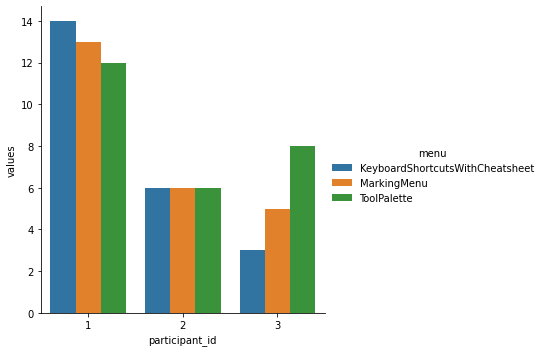

In [119]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='participant_id', y='values', hue='menu')

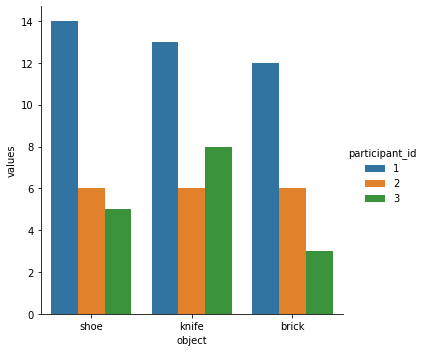

In [120]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='object', y='values', hue='participant_id')

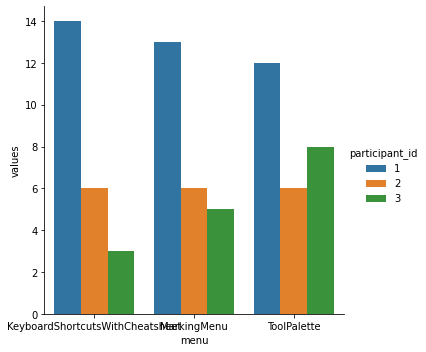

In [121]:
sns.catplot(data=unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index(), kind="bar", x='menu', y='values', hue='participant_id')

In [122]:
unusual_uses.groupby(['participant_id','menu','object']).count()

values  topTwo
participant_id menu                            object                
1              KeyboardShortcutsWithCheatsheet shoe        14      14
               MarkingMenu                     knife       13      13
               ToolPalette                     brick       12      12
2              KeyboardShortcutsWithCheatsheet brick        6       6
               MarkingMenu                     shoe         6       6
               ToolPalette                     knife        6       6
3              KeyboardShortcutsWithCheatsheet brick        3       3
               MarkingMenu                     shoe         5       5
               ToolPalette                     knife        8       8

In [123]:
tlx = df[df['task'] == 'NasaTlx']


def extract_tlx(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)
    
    for log in row['logs']:
        if log['type'] == 'NasaTlx':
            return pd.Series(log['responses'])
        
tlx = pd.concat([tlx, tlx.apply(extract_tlx, axis=1)], axis=1)
tlx

,participant_id,metadata,tasks,DevTools,__INDEX__,participant_number,task,content,logs,menu,...,timeLimit,questions,filename,experimenter,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration
34,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675111371644}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,NaN,10,4,10,8,14,12
68,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675111871174}...",MarkingMenu,...,NaN,NaN,NaN,NaN,16,12,10,6,10,12
102,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675112193863}...",ToolPalette,...,NaN,NaN,NaN,NaN,10,18,10,16,16,14
139,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675107566735}...",ToolPalette,...,NaN,NaN,NaN,NaN,3,3,5,7,5,3
173,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675107788601}...",MarkingMenu,...,NaN,NaN,NaN,NaN,9,7,5,7,7,7
207,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675107959564}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,NaN,9,7,7,9,9,8
244,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675122624390}...",ToolPalette,...,NaN,NaN,NaN,NaN,8,1,2,8,7,4
278,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675122956890}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,NaN,6,1,2,16,13,10
312,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,NasaTlx,NaN,"[{'type': 'START', 'timestamp': 1675123449064}...",MarkingMenu,...,NaN,NaN,NaN,NaN,7,1,3,4,13,6


### Mental Demand

### Physical Demand

### Temporal Demand

### Performance

### Effort

### Frustration

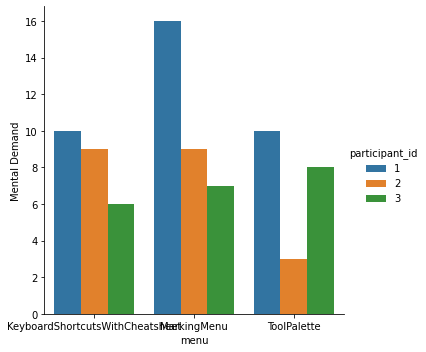

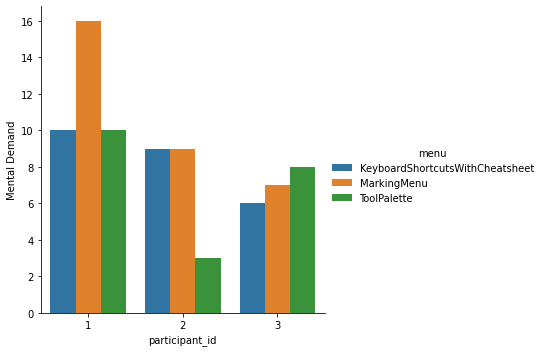

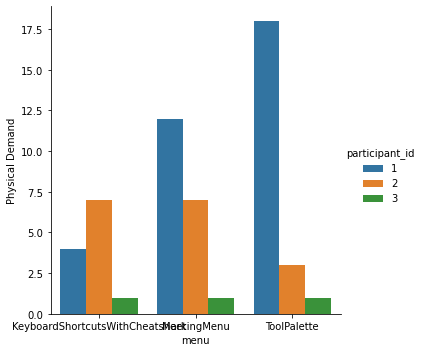

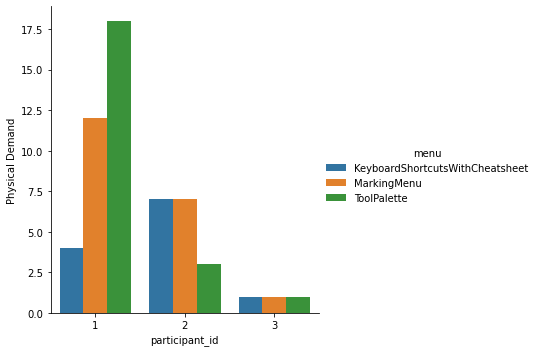

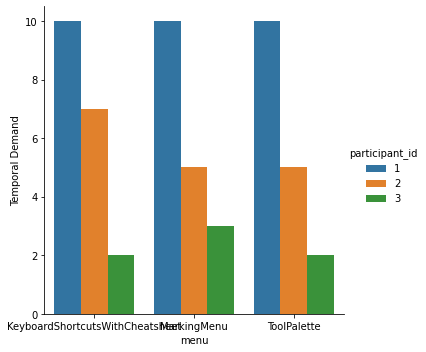

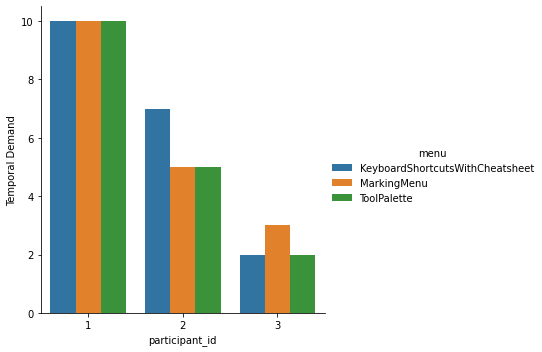

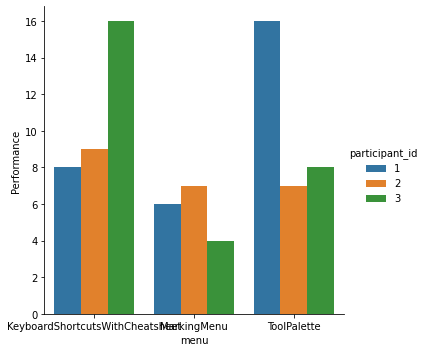

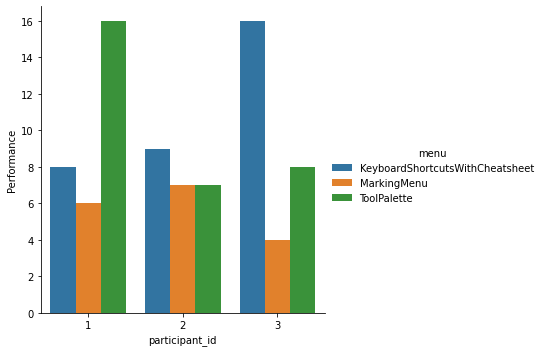

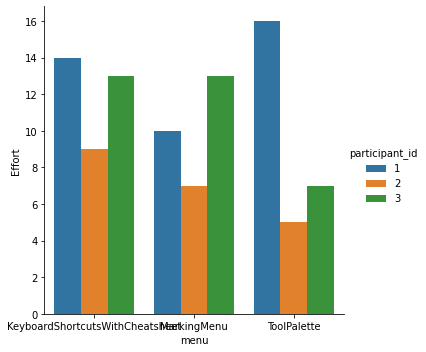

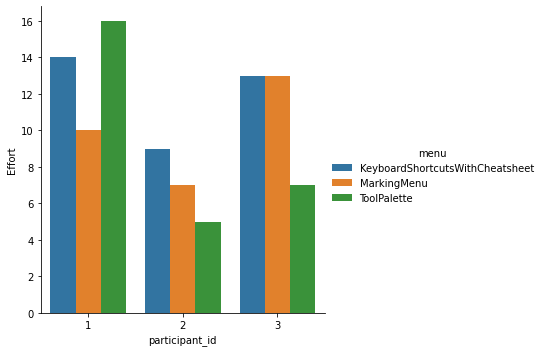

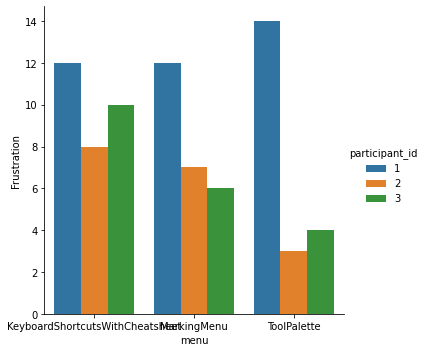

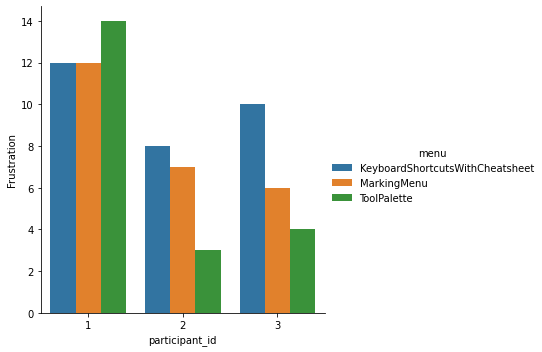

In [124]:
metrics = 'Mental Demand	Physical Demand	Temporal Demand	Performance	Effort	Frustration'.split('	')

for metric in metrics:
    display(Markdown(f'### {metric}'))
    sns.catplot(data=tlx, kind="bar", x='menu', y=metric, hue='participant_id')
    sns.catplot(data=tlx, kind="bar", x='participant_id', y=metric, hue='menu')

In [125]:
questionnaire = df[df['task'] == 'Questionnaire']

def extract_questionnaire(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)

    for log in row['logs']:
        if log['type'] == 'QuestionnaireResponses':
            return pd.Series(log['responses'])
        
questionnaire = pd.concat([questionnaire, questionnaire.apply(extract_questionnaire, axis=1)], axis=1)
questionnaire['felt'] = questionnaire['I felt creative while I was selecting commands.']
questionnaire['use'] = questionnaire['I would like to use that command selection technique while doing a creative task like drawing or writing a story.']

In [126]:
questionnaire

,participant_id,metadata,tasks,DevTools,__INDEX__,participant_number,task,content,logs,menu,...,question,object,timeLimit,questions,filename,experimenter,I felt creative while I was selecting commands.,I would like to use that command selection technique while doing a creative task like drawing or writing a story.,felt,use
33,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675111278196}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,8,77,8,77
67,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675111808635}...",MarkingMenu,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,45,55,45,55
101,1,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],0,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675112181930}...",ToolPalette,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,25,0,25,0
138,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107524570}...",ToolPalette,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,30,47,30,47
172,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107779810}...",MarkingMenu,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,35,60,35,60
206,2,"{""git_commit"":""3f9b2cc710a4b9cb4620695eaf653e7...","[""ProgressBar"",""DevTools""]","{""showInProduction"":true}",[4],1,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675107947549}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,19,25,19,25
243,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675122594372}...",ToolPalette,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,0,25,0,25
277,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675122943184}...",KeyboardShortcutsWithCheatsheet,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,4,10,4,10
311,3,"{""git_commit"":""0010ac92f48025bd22d773a1f482af6...","[""ProgressBar"",""DevTools""]","{""showInProduction"":false}",[4],2,Questionnaire,NaN,"[{'type': 'START', 'timestamp': 1675123441446}...",MarkingMenu,...,NaN,NaN,NaN,"[""I felt creative while I was selecting comman...",NaN,NaN,34,0,34,0


## I felt creative while I was selecting commands.

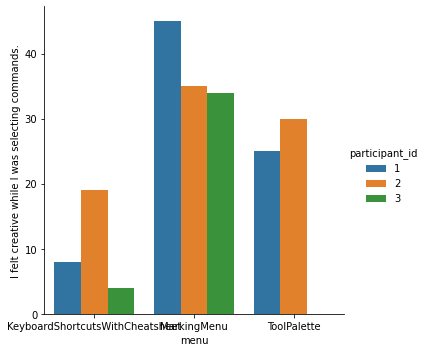

In [85]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='I felt creative while I was selecting commands.', hue='participant_id')

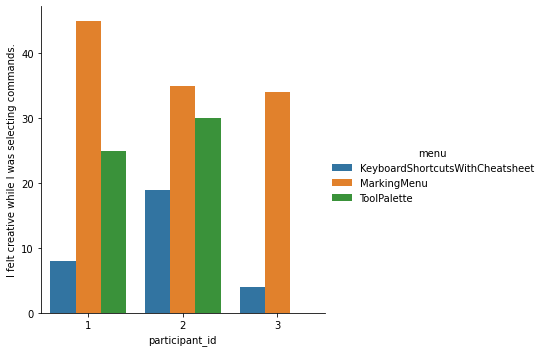

In [86]:
sns.catplot(data=questionnaire, kind="bar", x='participant_id', y='I felt creative while I was selecting commands.', hue='menu')

## I would like to use that command selection technique while doing a creative task like drawing or writing a story.

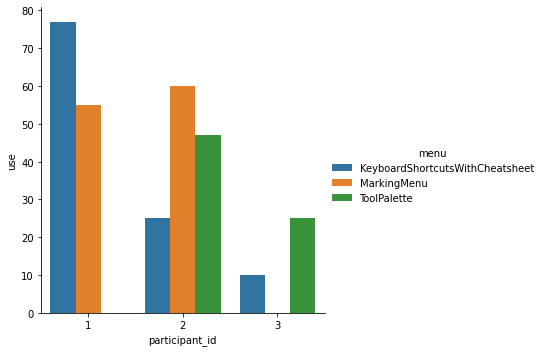

In [89]:
sns.catplot(data=questionnaire, kind="bar", x='participant_id', y='use', hue='menu')

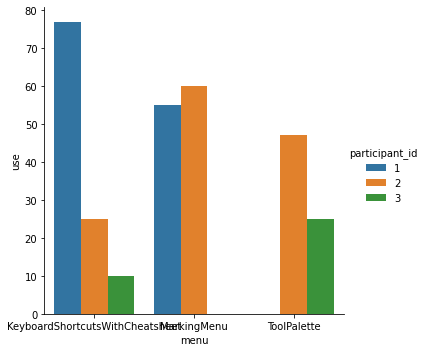

In [90]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='use', hue='participant_id')